# Comparing performance of  Target Encoder with Other Encoders

The TargetEncoder uses the value of the target to encode each categorical feature. In this example, we will compare three different approaches for handling categorical features: TargetEncoder, OrdinalEncoder, OneHotEncoder and dropping the category.



# 1. Loading data for Analysis

In [1]:
from sklearn.datasets import fetch_openml

wine_reviews = fetch_openml(data_id=42074, as_frame=True)

df = wine_reviews.frame
df.head()

,country,description,designation,points,price,province,region_1,region_2,variety,winery
0,US,This tremendous 100% varietal wine hails from ...,Martha's Vineyard,96,235.0,California,Napa Valley,Napa,Cabernet Sauvignon,Heitz
1,Spain,"Ripe aromas of fig, blackberry and cassis are ...",Carodorum Selección Especial Reserva,96,110.0,Northern Spain,Toro,NaN,Tinta de Toro,Bodega Carmen Rodríguez
2,US,Mac Watson honors the memory of a wine once ma...,Special Selected Late Harvest,96,90.0,California,Knights Valley,Sonoma,Sauvignon Blanc,Macauley
3,US,"This spent 20 months in 30% new French oak, an...",Reserve,96,65.0,Oregon,Willamette Valley,Willamette Valley,Pinot Noir,Ponzi
4,France,"This is the top wine from La Bégude, named aft...",La Brûlade,95,66.0,Provence,Bandol,NaN,Provence red blend,Domaine de la Bégude


In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150930 entries, 0 to 150929
Data columns (total 10 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   country      150925 non-null  object 
 1   description  150930 non-null  object 
 2   designation  105195 non-null  object 
 3   points       150930 non-null  int64  
 4   price        137235 non-null  float64
 5   province     150925 non-null  object 
 6   region_1     125870 non-null  object 
 7   region_2     60953 non-null   object 
 8   variety      150930 non-null  object 
 9   winery       150930 non-null  object 
dtypes: float64(1), int64(1), object(8)
memory usage: 11.5+ MB


In [3]:
df.describe()

,points,price
count,150930.000000,137235.000000
mean,87.888418,33.131482
std,3.222392,36.322536
min,80.000000,4.000000
25%,86.000000,16.000000
50%,88.000000,24.000000
75%,90.000000,40.000000
max,100.000000,2300.000000


In [4]:
df.describe(include='O')

,country,description,designation,province,region_1,region_2,variety,winery
count,150925,150930,105195,150925,125870,60953,150930,150930
unique,48,97821,30621,455,1236,18,632,14810
top,US,A little bit funky and unsettled when you pop ...,Reserve,California,Napa Valley,Central Coast,Chardonnay,Williams Selyem
freq,62397,6,2752,44508,6209,13057,14482,374


# 2. Subseting the data for the analysis

In [5]:
numerical_features = ["price"]
categorical_features = [
    "country",
    "province",
    "region_1",
    "region_2",
    "variety",
    "winery",
]
target_name = "points"

X = df[numerical_features + categorical_features]
y = df[target_name]

In [6]:
X.head()

,price,country,province,region_1,region_2,variety,winery
0,235.0,US,California,Napa Valley,Napa,Cabernet Sauvignon,Heitz
1,110.0,Spain,Northern Spain,Toro,NaN,Tinta de Toro,Bodega Carmen Rodríguez
2,90.0,US,California,Knights Valley,Sonoma,Sauvignon Blanc,Macauley
3,65.0,US,Oregon,Willamette Valley,Willamette Valley,Pinot Noir,Ponzi
4,66.0,France,Provence,Bandol,NaN,Provence red blend,Domaine de la Bégude


In [9]:
y.describe()

,points
count,150930.000000
mean,87.888418
std,3.222392
min,80.000000
25%,86.000000
50%,88.000000
75%,90.000000
max,100.000000


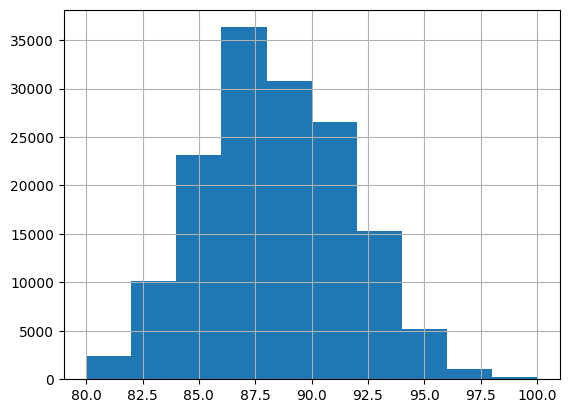

In [12]:
y.hist();

# 3. Training and Evaluating Pipelines with Different Encoders

In [13]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, TargetEncoder

categorical_preprocessors = [
    ("drop", "drop"),
    ("ordinal", OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1)),
    (
        "one_hot",
        OneHotEncoder(handle_unknown="ignore", max_categories=20, sparse_output=False),
    ),
    ("target", TargetEncoder(target_type="continuous")),
]

# 4. Evaluate the models using cross validation and record the results

In [14]:
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.model_selection import cross_validate
from sklearn.pipeline import make_pipeline

n_cv_folds = 3
max_iter = 20
results = []


def evaluate_model_and_store(name, pipe):
    result = cross_validate(
        pipe,
        X,
        y,
        scoring="neg_root_mean_squared_error",
        cv=n_cv_folds,
        return_train_score=True,
    )
    rmse_test_score = -result["test_score"]
    rmse_train_score = -result["train_score"]
    results.append(
        {
            "preprocessor": name,
            "rmse_test_mean": rmse_test_score.mean(),
            "rmse_test_std": rmse_train_score.std(),
            "rmse_train_mean": rmse_train_score.mean(),
            "rmse_train_std": rmse_train_score.std(),
        }
    )

In [15]:
for name, categorical_preprocessor in categorical_preprocessors:
    preprocessor = ColumnTransformer(
        [
            ("numerical", "passthrough", numerical_features),
            ("categorical", categorical_preprocessor, categorical_features),
        ]
    )
    pipe = make_pipeline(
        preprocessor, HistGradientBoostingRegressor(random_state=0, max_iter=max_iter)
    )
    evaluate_model_and_store(name, pipe)

# 5. Native Categorical Feature Support

we build and evaluate a pipeline that uses native categorical feature support in HistGradientBoostingRegressor, which only supports up to 255 unique categories. In our dataset, the most of the categorical features have more than 255 unique categories

In [16]:
n_unique_categories = df[categorical_features].nunique().sort_values(ascending=False)
n_unique_categories

,0
winery,14810
region_1,1236
variety,632
province,455
country,48
region_2,18


In [24]:
df.winery.nunique()

14810

To workaround the limitation above, we group the categorical features into low cardinality and high cardinality features. The high cardinality features will be target encoded and the low cardinality features will use the native categorical feature in gradient boosting

In [25]:
high_cardinality_features = n_unique_categories[n_unique_categories > 255].index
low_cardinality_features = n_unique_categories[n_unique_categories <= 255].index
print(f"High cardinality features: {high_cardinality_features}")
print(f"Low cardinality features: {low_cardinality_features}")
mixed_encoded_preprocessor = ColumnTransformer(
    [
        ("numerical", "passthrough", numerical_features),
        (
            "high_cardinality",
            TargetEncoder(target_type="continuous"),
            high_cardinality_features,
        ),
        (
            "low_cardinality",
            OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1),
            low_cardinality_features,
        ),
    ],
    verbose_feature_names_out=False,
)

# The output of the of the preprocessor must be set to pandas so the
# gradient boosting model can detect the low cardinality features.
mixed_encoded_preprocessor.set_output(transform="pandas")
mixed_pipe = make_pipeline(
    mixed_encoded_preprocessor,
    HistGradientBoostingRegressor(
        random_state=0, max_iter=max_iter, categorical_features=low_cardinality_features
    ),
)
mixed_pipe

High cardinality features: Index(['winery', 'region_1', 'variety', 'province'], dtype='object')
Low cardinality features: Index(['country', 'region_2'], dtype='object')


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('numerical', 'passthrough',
                                                  ['price']),
                                                 ('high_cardinality',
                                                  TargetEncoder(target_type='continuous'),
                                                  Index(['winery', 'region_1', 'variety', 'province'], dtype='object')),
                                                 ('low_cardinality',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  Index(['country', 'region_2'], dtype='object'))],
                                   verbose_feature_names_out=False)),
                ('histgradientboostingregressor',
                 HistGradientBoostingRegressor(categorical_features=Index(['country', 'region_2'], dtype='object'),
                                               max_iter=20, random_state=0))])

In [26]:
evaluate_model_and_store("mixed_target", mixed_pipe)

# 6. Plotting the Results

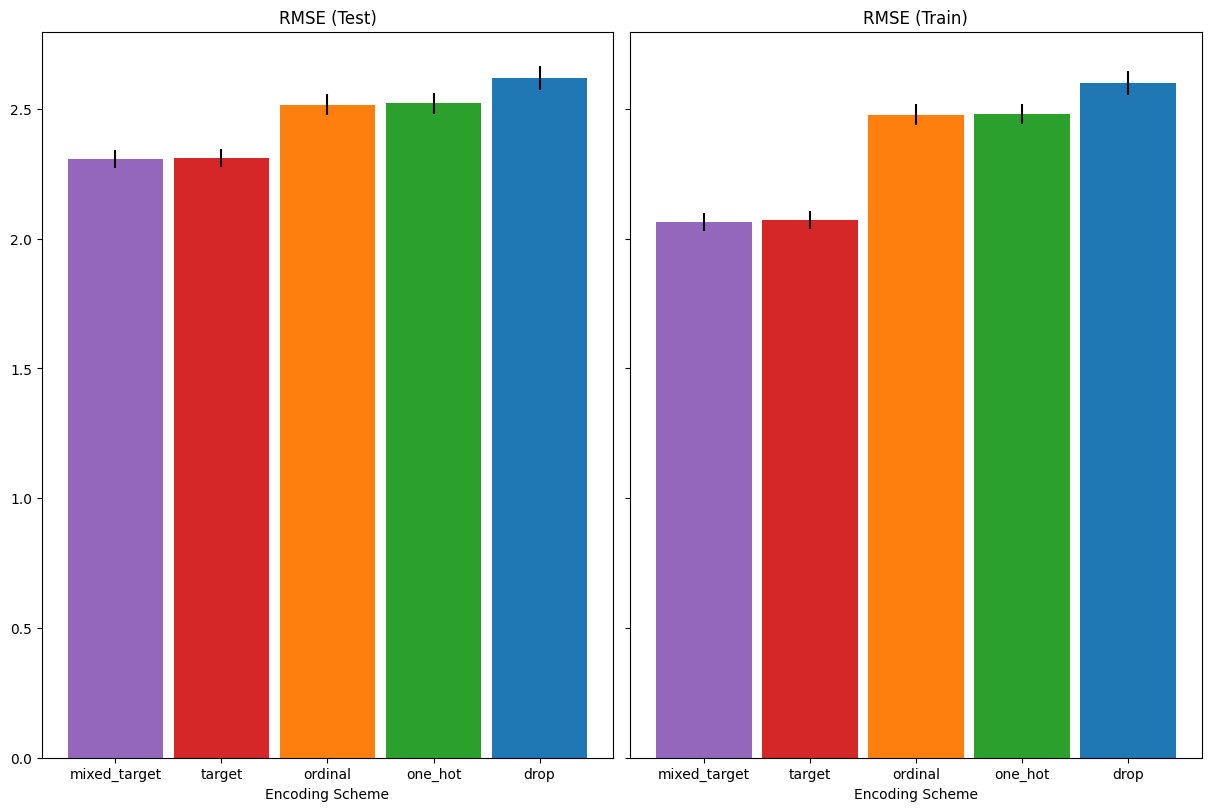

In [27]:
import matplotlib.pyplot as plt
import pandas as pd

results_df = (
    pd.DataFrame(results).set_index("preprocessor").sort_values("rmse_test_mean")
)

fig, (ax1, ax2) = plt.subplots(
    1, 2, figsize=(12, 8), sharey=True, constrained_layout=True
)
xticks = range(len(results_df))
name_to_color = dict(
    zip((r["preprocessor"] for r in results), ["C0", "C1", "C2", "C3", "C4"])
)

for subset, ax in zip(["test", "train"], [ax1, ax2]):
    mean, std = f"rmse_{subset}_mean", f"rmse_{subset}_std"
    data = results_df[[mean, std]].sort_values(mean)
    ax.bar(
        x=xticks,
        height=data[mean],
        yerr=data[std],
        width=0.9,
        color=[name_to_color[name] for name in data.index],
    )
    ax.set(
        title=f"RMSE ({subset.title()})",
        xlabel="Encoding Scheme",
        xticks=xticks,
        xticklabels=data.index,
    )

When evaluating the predictive performance on the test set, dropping the categories perform the worst and the target encoders performs the best. This can be explained as follows:

1. Dropping the categorical features makes the pipeline less expressive and underfitting as a result

2. Due to the high cardinality and to reduce the training time, the one-hot encoding scheme uses max_categories=20 which prevents the features from expanding too much, which can result in underfitting.

3. If we had not set max_categories=20, the one-hot encoding scheme would have likely made the pipeline overfitting as the number of features explodes with rare category occurrences that are correlated with the target by chance (on the training set only)

4. The ordinal encoding imposes an arbitrary order to the features which are then treated as numerical values by the HistGradientBoostingRegressor. Since this model groups numerical features in 256 bins per feature, many unrelated categories can be grouped together and as a result overall pipeline can underfit

5. When using the target encoder, the same binning happens, but since the encoded values are statistically ordered by marginal association with the target variable, the binning use by the HistGradientBoostingRegressor makes sense and leads to good results: the combination of smoothed target encoding and binning works as a good regularizing strategy against overfitting while not limiting the expressiveness of the pipeline too much.